In [1]:
import sys
sys.path.append("../src")

%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df_x_train = pd.read_csv("../data/X_train.csv", index_col="id")
df_y_train = pd.read_csv("../data/y_train.csv", index_col="id")

In [3]:
# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_x_train, df_y_train, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1) 

## 1) Training

### 1.1) Model

In [12]:
selector_model = XGBRegressor(
    n_estimators = 850,
    learning_rate = 0.015,
    random_state = 42,
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', XGBRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__n_neighbors=5,
    regression_model__n_estimators=800,
    regression_model__learning_rate=0.002,
    regression_model__subsample=0.6
)

Pipeline(steps=[('scaler', RobustScaler()), ('imputer', KNNImputer()),
                ('feature_selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device='gpu',
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        g...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.002,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [13]:
# Train model
start_t = time()

pipe.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 1.152 min


In [14]:
# Evaluate model on validation set
train_pred = pipe.predict(X_train)
val_pred = pipe.predict(X_val)

validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}") # 

Training score 0.784
Validation score 0.468


### 1.2) Hyperparameter tuning

In [7]:
selector_model = XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.02,
    random_state = 42
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', XGBRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__n_neighbors=5,
    regression_model__n_jobs=9
)

Pipeline(steps=[('scaler', RobustScaler()), ('imputer', KNNImputer()),
                ('feature_selector',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        device=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        feature_types=None,
                                                        gamma=None,
                                                        gr...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=9,
                              num_parallel_tree=None, random_state=None, ...))])

In [8]:
# Grid search of hyperparams
start_t = time()

# Set grid
parameters = {
    'regression_model__n_estimators': [200, 400, 600, 800, 1000],
    'regression_model__learning_rate': [0.002],
    'regression_model__subsample': [0.6]
}

# Do grid search
tuned_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=9, cv=5, return_train_score=True)
tuned_model.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 32.636 min


In [9]:
# Collect evaluation data into a data frame
df_cv_results = pd.DataFrame(tuned_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", ascending=False, inplace=True)

In [10]:
# Score and params of best model
params_col = []
for col in df_cv_results.columns:
    if ('param' in col) and col != "params":
        params_col.append(col)

df_cv_results.loc[df_cv_results.rank_test_score==1, ['mean_test_score', 
                                                     'std_test_score', 
                                                     'mean_train_score',
                                                     'std_train_score'
                                                    ]+params_col
].transpose()

,4
mean_test_score,0.455049
std_test_score,0.04439
mean_train_score,0.849116
std_train_score,0.006175
param_regression_model__learning_rate,0.002
param_regression_model__n_estimators,1000
param_regression_model__subsample,0.6


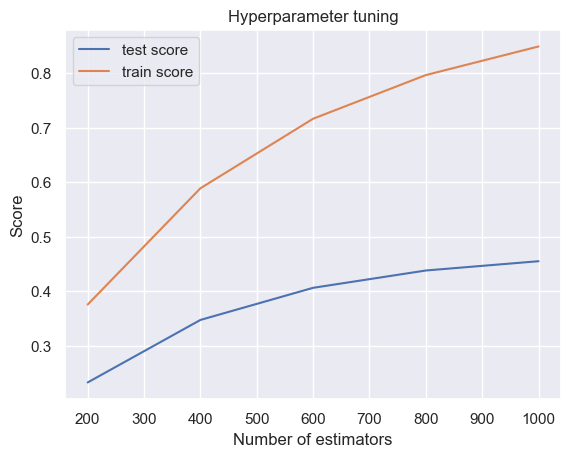

In [11]:
_param = 'regression_model__n_estimators'
plt.plot(df_cv_results[_param], df_cv_results['mean_test_score'], label = "test score")
plt.plot(df_cv_results[_param], df_cv_results['mean_train_score'], label = "train score")
plt.legend()
plt.xlabel('Number of estimators')
plt.ylabel('Score')
plt.title('Hyperparameter tuning');